First, we'll initialise a valve from the documentation

In [1]:
import pytest
import pyomo.environ as pyo
from pyomo.network import Arc
from idaes.core import FlowsheetBlock, MaterialBalanceType
from idaes.models.unit_models import Heater, Valve
from idaes.models.properties import iapws95
from idaes.core.util.initialization import propagate_state
from idaes.models.control.controller import (
    PIDController,
    ControllerType,
    ControllerMVBoundType,
)
import idaes.core.util.scaling as iscale
from idaes.core.solvers import get_solver, petsc
from surrogate_valve import _valve_pressure_flow_cb # used so the plant model has the exact pressure-flow relationship as the surrogate model

time_set=[0,12]
fs_cfg = {"dynamic": True, "time_set": time_set, "time_units": pyo.units.s}
model_name = "Steam Tank, Dynamic"

m = pyo.ConcreteModel(name=model_name)
m.fs = FlowsheetBlock(**fs_cfg)
# Create a property parameter block
m.fs.prop_water = iapws95.Iapws95ParameterBlock(
    phase_presentation=iapws95.PhaseType.LG
)
# Create the valve and tank models
m.fs.valve_1 = Valve(
    dynamic=False,
    has_holdup=False,
    pressure_flow_callback=_valve_pressure_flow_cb,
    material_balance_type=MaterialBalanceType.componentTotal,
    property_package=m.fs.prop_water,
)
m.fs.tank = Heater(
    has_holdup=True,
    material_balance_type=MaterialBalanceType.componentTotal,
    property_package=m.fs.prop_water,
)
m.fs.valve_2 = Valve(
    dynamic=False,
    has_holdup=False,
    pressure_flow_callback=_valve_pressure_flow_cb,
    material_balance_type=MaterialBalanceType.componentTotal,
    property_package=m.fs.prop_water,
)
# Add a controller
m.fs.ctrl = PIDController(
    process_var=m.fs.tank.control_volume.properties_out[:].pressure,
    manipulated_var=m.fs.valve_1.valve_opening,
    calculate_initial_integral=True, #  calculate in the initial condition for the integral term
    mv_bound_type=ControllerMVBoundType.SMOOTH_BOUND,
    controller_type=ControllerType.PI,
)
# The control volume block doesn't assume the two phases are in equilibrium
# by default, so I'll make that assumption here, I don't actually expect
# liquid to form but who knows. The phase_fraction in the control volume is
# volumetric phase fraction hence the densities.
@m.fs.tank.Constraint(m.fs.time)
def vol_frac_vap(b, t):
    return (
        b.control_volume.properties_out[t].phase_frac["Vap"]
        * b.control_volume.properties_out[t].dens_mol
        / b.control_volume.properties_out[t].dens_mol_phase["Vap"]
    ) == (b.control_volume.phase_fraction[t, "Vap"])

# Connect the models
m.fs.v1_to_tank = Arc(source=m.fs.valve_1.outlet, destination=m.fs.tank.inlet)
m.fs.tank_to_v2 = Arc(source=m.fs.tank.outlet, destination=m.fs.valve_2.inlet)

# Add the stream constraints and do the DAE transformation
pyo.TransformationFactory("network.expand_arcs").apply_to(m.fs)
pyo.TransformationFactory("dae.finite_difference").apply_to(
    m.fs, 
    nfe=300, # Number of finite elements to use for discretization 
    wrt=m.fs.time, 
    scheme="BACKWARD"
)

# Fix the derivative variables to zero at time 0 (steady state assumption)
m.fs.fix_initial_conditions()

# Fix the input variables
m.fs.valve_1.inlet.enth_mol.fix(50000)
m.fs.valve_1.inlet.pressure.fix(5e5)
m.fs.valve_2.outlet.pressure.fix(101325)
m.fs.valve_1.Cv.fix(0.001)
m.fs.valve_2.Cv.fix(0.001)
m.fs.valve_1.valve_opening.fix(1)
m.fs.valve_2.valve_opening.fix(1)
m.fs.tank.heat_duty.fix(0)
m.fs.tank.control_volume.volume.fix(2.0)

# Fix controller settings
m.fs.ctrl.gain_p.fix(1e-6)
m.fs.ctrl.gain_i.fix(1e-5)
# m.fs.ctrl.gain_d.fix(1e-6)
# m.fs.ctrl.derivative_of_error[m.fs.time.first()].fix(0)
m.fs.ctrl.setpoint.fix(3e5)
m.fs.ctrl.mv_ref.fix(0)
m.fs.ctrl.mv_lb = 0.0
m.fs.ctrl.mv_ub = 1.0

for t in m.fs.time:
    m.fs.valve_1.inlet.flow_mol[t] = 100  # initial guess on flow
# simple initialize
m.fs.valve_1.initialize()
propagate_state(m.fs.v1_to_tank)
m.fs.tank.initialize()
propagate_state(m.fs.tank_to_v2)
# Can't specify both flow and outlet pressure so free the outlet pressure
# for initialization and refix it after.  Inlet flow gets fixed in init, but
# is unfixed for the final problem
m.fs.valve_2.outlet.pressure.unfix()
m.fs.valve_2.initialize()
m.fs.valve_2.outlet.pressure.fix(101325)
m.fs.valve_1.valve_opening.unfix()
m.fs.valve_1.valve_opening[m.fs.time.first()].fix()
# Return the model and solver

2024-06-26 10:17:56 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found
2024-06-26 10:17:56 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete
2024-06-26 10:17:59 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found
2024-06-26 10:18:00 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


# solve the model

In [2]:
# Print Degrees of Freedom
from idaes.core.util.model_statistics import degrees_of_freedom
print(f'degrees of freedom: {degrees_of_freedom}')

# solve the model

from pyomo.environ import SolverFactory

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6, 'max_iter': 5000}
results = solver.solve(m, tee=True)

degrees of freedom: <function degrees_of_freedom at 0x7fe91fec7f60>
Ipopt 3.13.2: tol=1e-06
max_iter=5000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HS

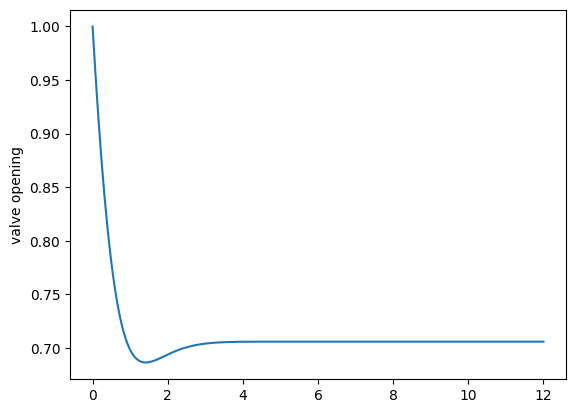

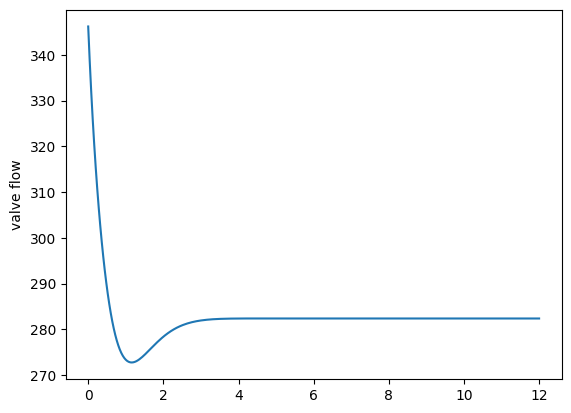

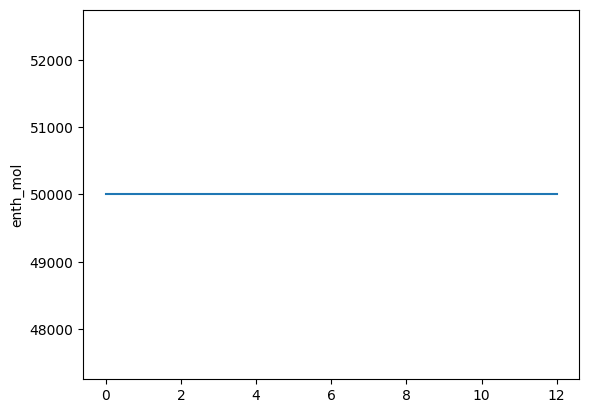

In [3]:
from matplotlib import pyplot as plt
timestamps = []
valve_opening_values = []
for name, value in sorted(m.fs.valve_1.valve_opening.get_values().items()):
    timestamps.append(name)
    valve_opening_values.append(value)
plt.plot(timestamps,valve_opening_values)
plt.ylabel('valve opening')
plt.show() 
timestamps = []
valve_flow_values = []
for name, value in sorted(m.fs.valve_1.inlet.flow_mol.get_values().items()):
    timestamps.append(name)
    valve_flow_values.append(value)
plt.plot(timestamps,valve_flow_values)
plt.ylabel('valve flow')
plt.show() 
timestamps = []
valve_flow_values = []
for name, value in sorted(m.fs.valve_1.inlet.enth_mol.get_values().items()):
    timestamps.append(name)
    valve_flow_values.append(value)
plt.plot(timestamps,valve_flow_values)
plt.ylabel('enth_mol')
plt.show() 



# Next steps

The above code doesn't do much, other than model the system and solve it using ipopt.
To get it to actually do mpc, you have to specify a bunch of stuff.

There are two competing libraries that could be helpful for this:

## Caprese

Idaes makes Caprese, which is enables *simulating* model predictive control. Potentially it could be used with pecos or or adjusted to be used with real models. 

a little documentation is found at https://idaes-pse.readthedocs.io/en/stable/explanations/modeling_extensions/caprese/nmpc.html?highlight=nmpc 

However, there isn't much more than that. As far as I can tell:

- the plant model is a pyomo/idaes model that represents the actual plant "blackbox" system you are trying to control. Theoretically, you could use live data instead of this.
- the plant timeset is the timeset that the plant model uses. e.g you might want to use a really detailed timeset for the plant model, so that it's really accurate?
- the controller model is the model that optimisation is performed on - the surrogate model/digital twin model you are using to predict what the "real" plant model is doing.
- the controller timeset is the timescale that the controller optimisation is performed on - e.g you might be able to optimise based on a finer resolution model than the number of readings you get from the plant.
- you need to specify the inputs at t0, which is the initial input the input the controller is giving the plant (after t0, the model predictive control will be figuring out the inputs for each timestep). These must be defined on the plant model, not the controller model, and are specified as an array of references to vars on the model
- you need to specify the measurements, which are vars/values of the controller that (i assume) are set from the output of the plant of the corresponding measurements. I'm not sure how you specify on the plant what things you need to measure.
- you need to specify the sample time, which is how often you get readings from the plant and (i assume) how often you update the plant.

There is an example of how it works here, with `cstr_rodrigo_model.py` used to generate a model (a function is used to generate a hi-fi "actual plant" model, and a low fi "controllers internal representation" model - note that this doesn't use idaes, it just uses pyomo directly). and `npmc_main.py` shows how to actually use the NMPCSim class that IDAES defines. it also includes some code to add noise to the measurements, as if the measurement equipment is imprecise, and for the inputs, as though you can't exactly control the system.
https://github.com/IDAES/idaes-pse/pull/412/files#diff-51858f72863a24df25a25a1090565c93edad18813d492ae1e65dfc0105884fb6


## Pyomo MPC

Pyomo also has a model predictive control library. I haven't really looked into it as much yet. However, the documentation is found at https://pyomo.readthedocs.io/en/stable/contributed_packages/mpc/overview.html

And there is an example of it being used https://github.com/Pyomo/pyomo/blob/7bbe3a7849f2511876118ba66132c6e7fd1dd344/pyomo/contrib/mpc/examples/cstr/run_mpc.py#L34 

## Next Steps

I could try go on a tangent, make an idaes surrogate model/ml model using pysmo or whatever, of this model. Then I can usee the surrogate model as the controller model, to simulate a lower-fidelity model.
then I can try using caprese or npmc or whatever to get it to work properly.

Then it would be a matter of figuring out how to use live data for a model, rather than using idaes to simulate a model. 
In some ways that might be simpler, as you only need one idaes model.

In parallel, I can work on loading data into an influxdb system, or using operator networks with idaes for surrogate modelling.

# Update: Trying Idaes Caprese NMPCSIM

We can use the model above to act as our "plant" model in a Nonlinear Model Predictive Control Simulation. This represents the "ground truth", simulated real world system, or the system we are trying to control.

However, we also need a controller_model, which is a simulation of the "ground truth", realworld plant. In this case, since we are only simulating model predictive control and not actually performing MPC, we are using a "simulation of a simulation" as the controller model. I will create an identical model to the one first created, but using a surrogate valve rather than an actual valve. I should learn how to surrogate model the tank as well, but that is more complex as it is a dynamic system rather than a steady-state system. Surrogate modelling the tank might be a good use of operator networks or something.

Anyways, for now, a copy-paste of the original model but with surrogate valves instead of actual valves

*Note, for this to work the surrogate_valve.py script needs to be run first to train the model and create the .json file*

In [4]:

from surrogate_valve import SurrogateValve

time_set=[0,12]
fs_cfg = {"dynamic": True, "time_set": time_set, "time_units": pyo.units.s}
model_name = "Steam Tank, Dynamic (surrogate valve)"

cm = pyo.ConcreteModel(name=model_name)
cm.fs = FlowsheetBlock(**fs_cfg)
# Create a property parameter block
cm.fs.prop_water = iapws95.Iapws95ParameterBlock(
    phase_presentation=iapws95.PhaseType.LG
)
# Create the valve and tank models
cm.fs.valve_1 = SurrogateValve(
    dynamic=False,
    has_holdup=False,
    material_balance_type=MaterialBalanceType.componentTotal,
    property_package=cm.fs.prop_water,
)
cm.fs.tank = Heater(
    has_holdup=True,
    material_balance_type=MaterialBalanceType.componentTotal,
    property_package=cm.fs.prop_water,
)
cm.fs.valve_2 = SurrogateValve(
    dynamic=False,
    has_holdup=False,
    material_balance_type=MaterialBalanceType.componentTotal,
    property_package=cm.fs.prop_water,
)
# Add a controller
cm.fs.ctrl = PIDController(
    process_var=cm.fs.tank.control_volume.properties_out[:].pressure,
    manipulated_var=cm.fs.valve_1.valve_opening,
    calculate_initial_integral=True, #  calculate in the initial condition for the integral term
    mv_bound_type=ControllerMVBoundType.SMOOTH_BOUND,
    controller_type=ControllerType.PI,
)
# The control volume block doesn't assume the two phases are in equilibrium
# by default, so I'll make that assumption here, I don't actually expect
# liquid to form but who knows. The phase_fraction in the control volume is
# volumetric phase fraction hence the densities.
@cm.fs.tank.Constraint(cm.fs.time)
def vol_frac_vap(b, t):
    return (
        b.control_volume.properties_out[t].phase_frac["Vap"]
        * b.control_volume.properties_out[t].dens_mol
        / b.control_volume.properties_out[t].dens_mol_phase["Vap"]
    ) == (b.control_volume.phase_fraction[t, "Vap"])

# Connect the models
cm.fs.v1_to_tank = Arc(source=cm.fs.valve_1.outlet, destination=cm.fs.tank.inlet)
cm.fs.tank_to_v2 = Arc(source=cm.fs.tank.outlet, destination=cm.fs.valve_2.inlet)

# Add the stream constraints and do the DAE transformation
pyo.TransformationFactory("network.expand_arcs").apply_to(cm.fs)
pyo.TransformationFactory("dae.finite_difference").apply_to(
    cm.fs, 
    nfe=300, # Number of finite elements to use for discretization 
    wrt=cm.fs.time, 
    scheme="BACKWARD"
)

# Fix the derivative variables to zero at time 0 (steady state assumption)
cm.fs.fix_initial_conditions()

# Fix the input variables
cm.fs.valve_1.inlet.enth_mol.fix(50000)
cm.fs.valve_1.inlet.pressure.fix(5e5)
cm.fs.valve_2.outlet.pressure.fix(101325)
cm.fs.valve_1.valve_opening.fix(1)
cm.fs.valve_2.valve_opening.fix(1)
cm.fs.tank.heat_duty.fix(0)
cm.fs.tank.control_volume.volume.fix(2.0)

# Fix controller settings
cm.fs.ctrl.gain_p.fix(1e-6)
cm.fs.ctrl.gain_i.fix(1e-5)
# m.fs.ctrl.gain_d.fix(1e-6)
# m.fs.ctrl.derivative_of_error[m.fs.time.first()].fix(0)
cm.fs.ctrl.setpoint.fix(3e5)
cm.fs.ctrl.mv_ref.fix(0)
cm.fs.ctrl.mv_lb = 0.0
cm.fs.ctrl.mv_ub = 1.0

for t in cm.fs.time:
    cm.fs.valve_1.inlet.flow_mol[t] = 100  # initial guess on flow
# simple initialize
cm.fs.valve_1.initialize()
propagate_state(cm.fs.v1_to_tank)
cm.fs.tank.initialize()
propagate_state(cm.fs.tank_to_v2)
# Can't specify both flow and outlet pressure so free the outlet pressure
# for initialization and refix it after.  Inlet flow gets fixed in init, but
# is unfixed for the final problem
cm.fs.valve_2.outlet.pressure.unfix()
cm.fs.valve_2.initialize()
cm.fs.valve_2.outlet.pressure.fix(101325)
cm.fs.valve_1.valve_opening.unfix()
cm.fs.valve_1.valve_opening[cm.fs.time.first()].fix()
# Return the model and solver

2024-06-26 10:19:18 [ERROR] idaes.core.base.process_block: Failure in build: fs.valve_1
Traceback (most recent call last):
  File "/home/bert/miniconda3/envs/idaes/lib/python3.11/site-packages/idaes/core/base/process_block.py", line 41, in _rule_default
    b.build()
  File "/home/bert/Downloads/model-predictive-control/surrogate_valve.py", line 192, in build
    make_control_volume(self, "control_volume", self.CONFIG)
  File "/home/bert/Downloads/model-predictive-control/surrogate_valve.py", line 155, in make_control_volume
    raise ValueError('SurrogateValve does not support dynamics')
ValueError: SurrogateValve does not support dynamics
ERROR: Constructing component 'fs.valve_1' from data=None failed: ValueError:
SurrogateValve does not support dynamics


ValueError: SurrogateValve does not support dynamics

## Check that the controller model works correctly

In [ ]:
# Print Degrees of Freedom
from idaes.core.util.model_statistics import degrees_of_freedom
print(f'degrees of freedom: {degrees_of_freedom}')

# solve the model
results = solver.solve(cm, tee=True)

timestamps = []
valve_opening_values = []
for name, value in sorted(m.fs.valve_1.valve_opening.get_values().items()):
    timestamps.append(name)
    valve_opening_values.append(value)
plt.plot(timestamps,valve_opening_values)
plt.ylabel('valve opening')
plt.show() 

Now, we can create the MPC simulation.

We need to identify which are our variables and which are our measurements.

In [ ]:
from idaes.apps.caprese.nmpc import NMPCSim

inputs = [
  
]

measurements = [
  
]

NMPCSim(
    plant_model=m,
    plant_time_set=m.fs.time,
    controller_model=cm,
    controller_time_set=cm.fs.time,
    inputs_at_t0=inputs,
    measurements=measurements,
    sample_time=1.0,
)

SyntaxError: invalid syntax (190060260.py, line 7)